<a href="https://colab.research.google.com/github/zhangxs131/Machine_learning_notebook/blob/main/AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##编写Adaboost

为了加深adaboost的算法隐形和记忆，需要进行编写程序实现

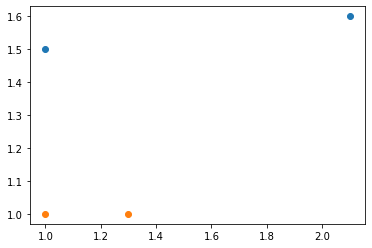

In [2]:
#加载简单数据
import numpy as np
import matplotlib.pyplot as plt

def loadSimpData():
  datMat = np.matrix([[ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
  classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
  return datMat,classLabels

#可视化二分类数据

def showData(dataMat,labelMat):
  data_plus=[]
  data_minus=[]
  for i in range(len(dataMat)):
    if labelMat[i]>0:
      data_plus.append(dataMat[i])
    else:
      data_minus.append(dataMat[i])
    
  plt.scatter(np.transpose(np.array(data_plus)[0]),np.transpose(np.array(data_plus)[1]))
  plt.scatter(np.transpose(np.array(data_minus)[0]),np.transpose(np.array(data_minus)[1]))
  plt.show()

data,label=loadSimpData()
showData(data,label)


In [10]:
#构建单层决策树分类器，根据阈值分类

def stumpClassify(data,dim,thresh,flag):
  ret=np.ones((data.shape[0],1))

  if flag=='lt':
    ret[data[:,dim]<=thresh]=-1.0
  else:
    ret[data[:,dim]>thresh]=-1.0
  return ret

def buildstump(data,label,D):
    dataMatrix = np.mat(data); labelMat = np.mat(label).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = float('inf')                                                        #最小误差初始化为正无穷大
    for i in range(n):                                                            #遍历所有特征
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()        #找到特征中最小的值和最大值
        stepSize = (rangeMax - rangeMin) / numSteps                                #计算步长
        for j in range(-1, int(numSteps) + 1):                                     
            for inequal in ['lt', 'gt']:                                          #大于和小于的情况，均遍历。lt:less than，gt:greater than
                threshVal = (rangeMin + float(j) * stepSize)                     #计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
                errArr = np.mat(np.ones((m,1)))                                 #初始化误差矩阵
                errArr[predictedVals == labelMat] = 0                             #分类正确的,赋值为0
                weightedError = D.T * errArr                                      #计算误差
                print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:                                     #找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

#样本权重
D=np.mat(np.ones((5,1))/5)
bestStump,minError,bestClassEst=buildstump(data,label,D)

print('bestStump:\n', bestStump)
print('minError:\n', minError)
print('bestClasEst:\n', bestClassEst)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50, thresh ineq

In [11]:
#加上adaboost进行加权分类器

def adaBoostTrain(data,label,numIt=40):
  weakClassArr=[]
  m=data.shape[0]
  D=np.mat(np.ones((m,1))/m)
  aggClassEst=np.mat(np.zeros((m,1)))

  for i in range(numIt):
    bestStump, error, classEst = buildstump(data, label, D)     #构建单层决策树
    print("D:",D.T)
    alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))         #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
    bestStump['alpha'] = alpha                                          #存储弱学习算法权重
    weakClassArr.append(bestStump)                                      #存储单层决策树
    print("classEst: ", classEst.T)
    expon = np.multiply(-1 * alpha * np.mat(label).T, classEst)     #计算e的指数项
    D = np.multiply(D, np.exp(expon))                                      
    D = D / D.sum()                                                        #根据样本权重公式，更新样本权重
    #计算AdaBoost误差，当误差为0的时候，退出循环
    aggClassEst += alpha * classEst                                 
    print("aggClassEst: ", aggClassEst.T)
    aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(label).T, np.ones((m,1)))     #计算误差
    errorRate = aggErrors.sum() / m
    print("total error: ", errorRate)

    if errorRate == 0.0: 
      break                                             #误差为0，退出循环
  return weakClassArr, aggClassEst

weekClassArr,aggClassEst=adaBoostTrain(data,label)
print(weekClassArr)
print(aggClassEst)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.50, thresh ineq

In [17]:
##对测试集进行预测

def adaClassify(test_data,classifier):
  data=np.array(test_data)
  m=data.shape[0]

  aggClassEst=np.mat(np.zeros((m,1)))
  for i in range(len(classifier)):
    classEst=stumpClassify(data,classifier[i]['dim'],classifier[i]['thresh'],classifier[i]['ineq'])
    aggClassEst+=classifier[i]['alpha']*classEst
  return np.sign(aggClassEst)

result=adaClassify([[0,0],[5,5]],weekClassArr)
result

matrix([[-1.],
        [ 1.]])

In [14]:
#在其他数据集进行实验
!wget https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/AdaBoost/horseColicTraining2.txt
!wget https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/AdaBoost/horseColicTest2.txt

--2022-05-04 08:00:37--  https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/AdaBoost/horseColicTraining2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60479 (59K) [text/plain]
Saving to: ‘horseColicTraining2.txt.1’

horseColicTraining2 100%[===================>]  59.06K  --.-KB/s    in 0.004s  

2022-05-04 08:00:37 (15.8 MB/s) - ‘horseColicTraining2.txt.1’ saved [60479/60479]

--2022-05-04 08:00:37--  https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/AdaBoost/horseColicTest2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request

In [ ]:
def loadDataSet(fileName):
    numFeat = len((open(fileName).readline().split('\t')))
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

data_horse,label_horse=loadDataSet('/content/horseColicTraining2.txt')
test_data,test_label=loadDataSet('/content/horseColicTest2.txt')

weekClassifier,aggClass=adaBoostTrain(np.mat(data_horse),label_horse,100)
print(weekClassifier)

predictions=adaClassify(data_horse,weekClassArr)
errArr=np.mat(np.ones((len(data_horse),1)))
print("train_dataset error rate is {:.2f}%".format(float(errArr[predictions!=np.mat(label_horse).T].sum()/len(data_horse)*100)))

predictions=adaClassify(test_data,weekClassArr)
errArr_test=np.mat(np.ones((len(test_data),1)))
print("test_dataset error rate is {:.2f}%".format(float(errArr_test[predictions!=np.mat(test_label).T].sum()/len(test_data)*100)))

##sklearn 实现adaBoostClassifier

参数设置：
*      base_estimator 基础分类器，默认决策树，可以选择cart，或MLP
*      algorithm 算法，默认SAMME.R 决定弱学习器权重度量
*      n_estimators  最大迭代次数
*      learning_rate  每个弱学习器，权重衰减系数

In [24]:
#对上面的数据集进行实验
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt=AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm='SAMME',n_estimators=10)
bdt.fit(data_horse,label_horse)

predictions=bdt.predict(data_horse)
errArr=np.mat(np.ones((len(data_horse),1)))
print("train_dataset error rate is {:.2f}%".format(float(errArr[predictions!=label_horse].sum()/len(data_horse)*100)))

predictions_2=bdt.predict(test_data)
errArr_test=np.mat(np.ones((len(test_data),1)))
print("test_dataset error rate is {:.2f}%".format(float(errArr_test[predictions_2!=test_label].sum()/len(test_data)*100)))

train_dataset error rate is 16.05%
test_dataset error rate is 17.91%
